In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import glob
import time
import math
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from IPython.display import HTML
from scipy import ndimage as ndi
from skimage.feature import hog
from moviepy.editor import VideoFileClip
from IPython.display import Audio

global enable_diag
enable_diag = False

global heat_threshold
heat_threshold = 3

%matplotlib inline

sound_file = './beep.wav'


In [2]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

### **Most of these functions have been extracted from the lessons**

In [3]:
# Define a function to return HOG features and visualization
# from lesson
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
# from lesson
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
# from lesson
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
# from lesson
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
# from lesson
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
# from lesson
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# from lesson
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    on_windows = []
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = clf.predict(test_features)
        if prediction == 1:
            on_windows.append(window)

    return on_windows

# from lesson
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    img_features = []
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      

    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    if hist_feat == True:
        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins, 
                                    bins_range=hist_range)
        img_features.append(hist_features)
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        img_features.append(hog_features)

    # Return list of feature vectors
    return np.concatenate(img_features)

# from lesson
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    heatmap = heatmap * 1.25
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def get_bboxes(labels):
    # Iterate through all detected cars
    bbox_list = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bbox_list.append(bbox)
    bbox_list = np.array(bbox_list)
    return bbox_list

def create_car_windows(box_list, image):
    global heat_threshold

    if len(box_list)>0:
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        heat = add_heat(heat,box_list)

        # Apply threshold to help remove false positives
        heat = apply_threshold(heat, heat_threshold)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = ndi.label(heatmap)
        newbox_list = get_bboxes(labels)

        draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img, newbox_list


In [28]:
save_features = True
save_model = True

if save_features:
    # Read in cars and notcars dataset from files
    cars = []
    notcars = []

    tic=time.time()
    cars = glob.glob('./../Vehicle_detection_dataset/vehicles/**/*.png')
    notcars = glob.glob('./../Vehicle_detection_dataset/non-vehicles/**/*.png')
    
    print("cars size:", len(cars))
    print("notcars size:", len(notcars))
    
    # parameters as a dictionary
    parameters = {'color_space': color_space,
                  'orient': orient,
                  'pix_per_cell': pix_per_cell,
                  'cell_per_block': cell_per_block,
                  'hog_channel': hog_channel,
                  'spatial_size': spatial_size,
                  'hist_bins': hist_bins,
                  'spatial_feat': spatial_feat,
                  'hist_feat': hist_feat,
                  'hog_feat': hog_feat}

    car_features = extract_features(cars, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    
    notcar_features = extract_features(notcars, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

    toc = time.time()
    
    print (('It took: %.2f s to extract the features') % (toc-tic))

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))

    # Save the data for easy access
    pickle_file = 'features.pickle'
    if not os.path.isfile(pickle_file):
        print('Saving data to pickle file...')
        try:
            with open(pickle_file, 'wb') as pfile:
                pickle.dump(
                    {
                        'train_dataset': X_train,
                        'train_labels': y_train,
                        'test_dataset': X_test,
                        'test_labels': y_test,
                        'X_scaler': X_scaler,
                        'parameters': parameters
                    },
                    pfile, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print('Unable to save data to', pickle_file, ':', e)
            raise

if save_model:
    # Reload the data
    pickle_file = 'features.pickle'
    with open(pickle_file, 'rb') as f:
        pickle_data = pickle.load(f)
        X_train = pickle_data['train_dataset']
        y_train = pickle_data['train_labels']
        X_test = pickle_data['test_dataset']
        y_test = pickle_data['test_labels']
        X_scaler = pickle_data['X_scaler']
        parameters = pickle_data['parameters']
        del pickle_data  # Free up memory

    print('Data and modules loaded.')
    print("train_features size:", X_train.shape)
    print("train_labels size:", y_train.shape)
    print("test_features size:", X_test.shape)
    print("test_labels size:", y_test.shape)
    for k in parameters:
        print(k, ":", parameters[k])

    color_space = parameters['color_space']
    orient = parameters['orient']
    pix_per_cell = parameters['pix_per_cell']
    cell_per_block = parameters['cell_per_block']
    hog_channel = parameters['hog_channel']
    spatial_size = parameters['spatial_size']
    hist_bins = parameters['hist_bins']
    spatial_feat = parameters['spatial_feat']
    hist_feat = parameters['hist_feat']
    hog_feat = parameters['hog_feat']

    print('\nUsing:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')

    # Use a linear SVC 
    svc = LinearSVC(max_iter=20000)
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()

    # Save the model for easy access later
    pickle_file = 'svc.pickle'
    if not os.path.isfile(pickle_file):
        print('Saving data to pickle file...')
        try:
            with open(pickle_file, 'wb') as pfile:
                pickle.dump(
                    {
                        'svc': svc,
                        'X_scaler': X_scaler,
                        'parameters': parameters
                    },
                    pfile, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print('Unable to save data to', pickle_file, ':', e)
            raise


cars size: 8792
notcars size: 8968
It took: 30.99 s to extract the features
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2580
Data and modules loaded.
train_features size: (14208, 2580)
train_labels size: (14208,)
test_features size: (3552, 2580)
test_labels size: (3552,)
color_space : YCrCb
hog_feat : True
spatial_size : (16, 16)
cell_per_block : 2
pix_per_cell : 8
hog_channel : 0
orient : 9
hist_bins : 16
hist_feat : True
spatial_feat : True

Using: 9 orientations 8 pixels per cell and 2 cells per block
115.58 Seconds to train SVC...
Test Accuracy of SVC =  0.9755


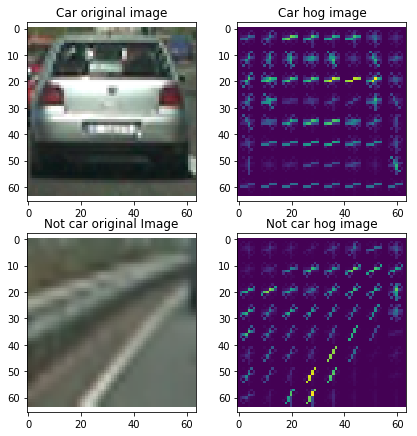

In [27]:
car_path = ('./../Vehicle_detection_dataset/vehicles/GTI_MiddleClose/image0108.png')
notcar_path = ('./../Vehicle_detection_dataset/non-vehicles/GTI/image7.png')
car_img = mpimg.imread(car_path)
notcar_img = mpimg.imread(notcar_path)
car_img_gs = cv2.cvtColor(car_img, cv2.COLOR_RGB2GRAY)
notcar_img_gs = cv2.cvtColor(notcar_img, cv2.COLOR_RGB2GRAY)

features, car_hog_image = get_hog_features(car_img_gs, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
features, notcar_hog_image = get_hog_features(notcar_img_gs, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

#plt.rcParams['figure.figsize'] = (6.0, 6.0)
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey='col', sharex='row', figsize=(6,6))
f.tight_layout()

ax1.set_title('Car original image', fontsize=12)
ax1.imshow(car_img)

ax2.set_title('Car hog image', fontsize=12)
ax2.imshow(car_hog_image)

ax3.set_title('Not car original Image', fontsize=12)
ax3.imshow(notcar_img)

ax4.set_title('Not car hog image', fontsize=12)
ax4.imshow(notcar_hog_image)
plt.show()

In [9]:
# Reload the model data
pickle_file = 'svc.pickle'
with open(pickle_file, 'rb') as f:
    pickle_data = pickle.load(f)
    svc = pickle_data['svc']
    X_scaler = pickle_data['X_scaler']
    parameters = pickle_data['parameters']
    del pickle_data 


color_space = parameters['color_space']
orient = parameters['orient']
pix_per_cell = parameters['pix_per_cell']
cell_per_block = parameters['cell_per_block']
hog_channel = parameters['hog_channel']
spatial_size = parameters['spatial_size']
hist_bins = parameters['hist_bins']
spatial_feat = parameters['spatial_feat']
hist_feat = parameters['hist_feat']
hog_feat = parameters['hog_feat']

print('Model and parameters loaded.')


# Create the sliding windows
image = mpimg.imread('./test_images/test3.jpg')

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[375, 475], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))
windows += slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 500], 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))
windows += slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 500], 
                    xy_window=(144, 144), xy_overlap=(0.75, 0.75))
windows += slide_window(image, x_start_stop=[None, None], y_start_stop=[430, 550], 
                    xy_window=(192, 192), xy_overlap=(0.75, 0.75))
windows += slide_window(image, x_start_stop=[None, None], y_start_stop=[460, 580], 
                    xy_window=(192, 192), xy_overlap=(0.75, 0.75))

def process_single_image(image):
    # Save a raw image
    result_image = np.copy(image)
    
    # Normalize image
    image = image.astype(np.float32)/255
    
    # Apply pipeline to the image to create black and white image
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, spatial_size=spatial_size, 
                        hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

    # Draw hot windows into original image
    result_image = draw_boxes(result_image, hot_windows, color=(255, 0, 0), thick=6)

    # Return an image with the boxes
    return result_image, hot_windows

Model and parameters loaded.


Search windows


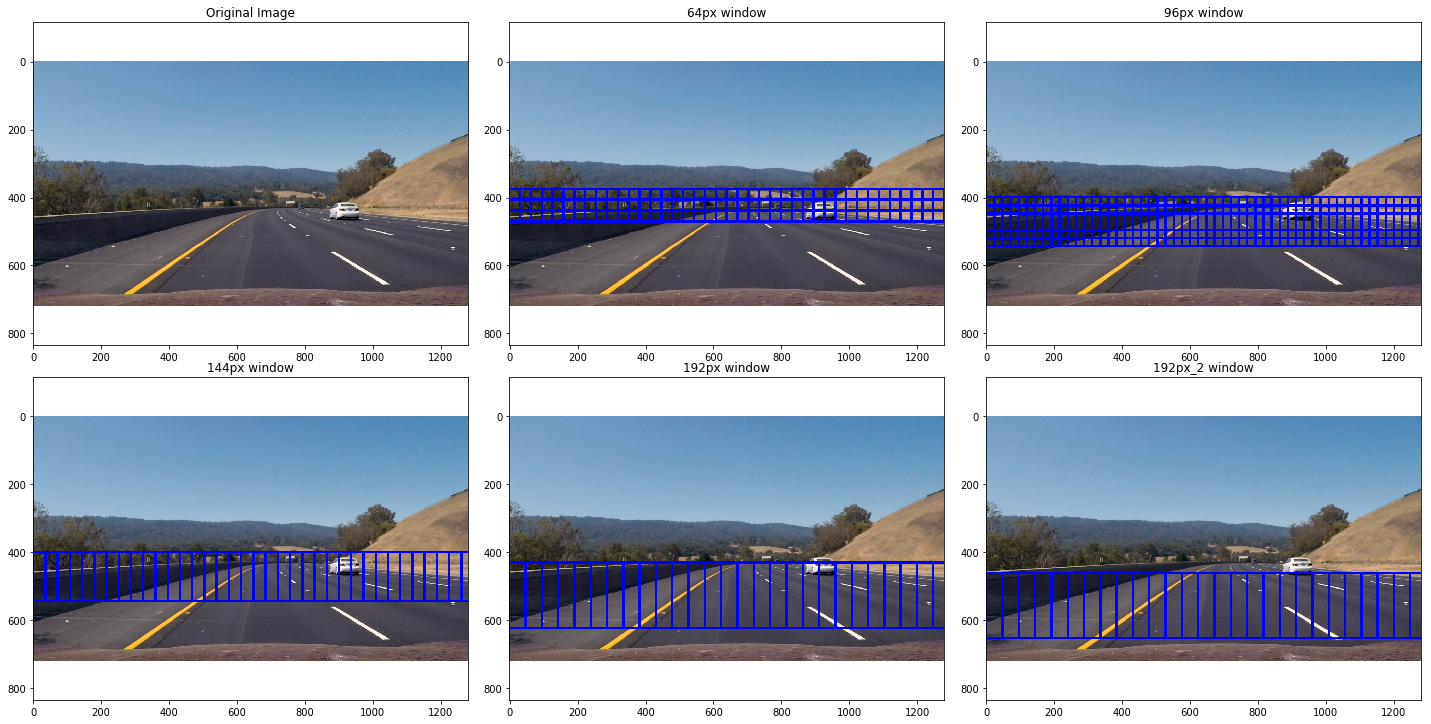

In [19]:
print ('Search windows')
windows_64 = slide_window(image, x_start_stop=[None, None], y_start_stop=[375, 475], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))
windows_96 = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 500], 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))
windows_144 = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 500], 
                    xy_window=(144, 144), xy_overlap=(0.75, 0.75))
windows_192 = slide_window(image, x_start_stop=[None, None], y_start_stop=[430, 550], 
                    xy_window=(192, 192), xy_overlap=(0.75, 0.75))
windows_192_2 = slide_window(image, x_start_stop=[None, None], y_start_stop=[460, 580], 
                    xy_window=(192, 192), xy_overlap=(0.75, 0.75))

plt.rcParams['figure.figsize'] = (20.0, 10.0)

f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharey='col', sharex='row', figsize=(20,10))
f.tight_layout()

ax1.set_title('Original Image', fontsize=12)
ax1.imshow((image).astype('uint8'))

ax2.set_title('64px window', fontsize=12)
ax2.imshow((draw_boxes(image, windows_64, color=(0, 0, 255), thick=6 )).astype('uint8'))

ax3.set_title('96px window', fontsize=12)
ax3.imshow((draw_boxes(image, windows_96, color=(0, 0, 255), thick=6 )).astype('uint8'))

ax4.set_title('144px window', fontsize=12)
ax4.imshow((draw_boxes(image, windows_144, color=(0, 0, 255), thick=6 )).astype('uint8'))

ax5.set_title('192px window', fontsize=12)
ax5.imshow((draw_boxes(image, windows_192, color=(0, 0, 255), thick=6 )).astype('uint8'))

ax6.set_title('192px_2 window', fontsize=12)
ax6.imshow((draw_boxes(image, windows_192_2, color=(0, 0, 255), thick=6 )).astype('uint8'))


plt.show()

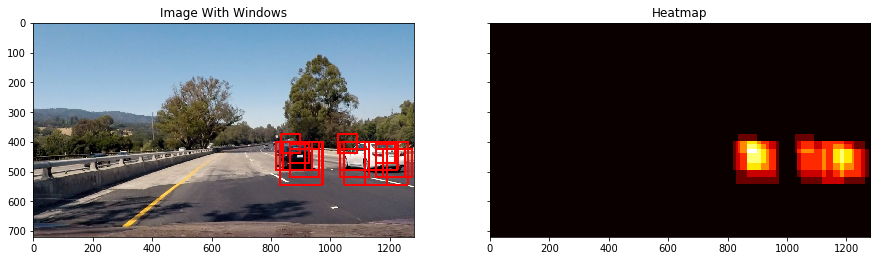

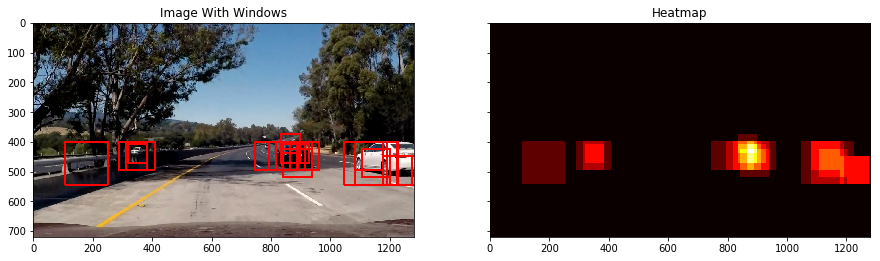

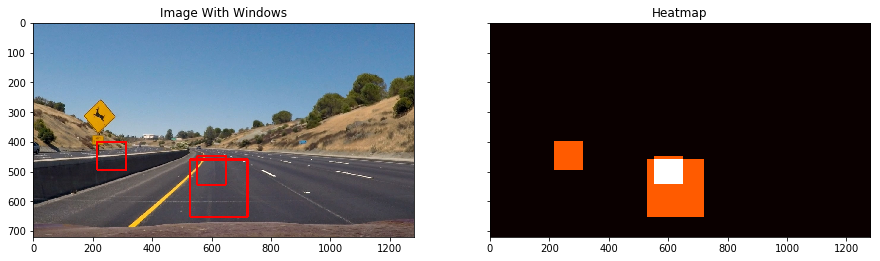

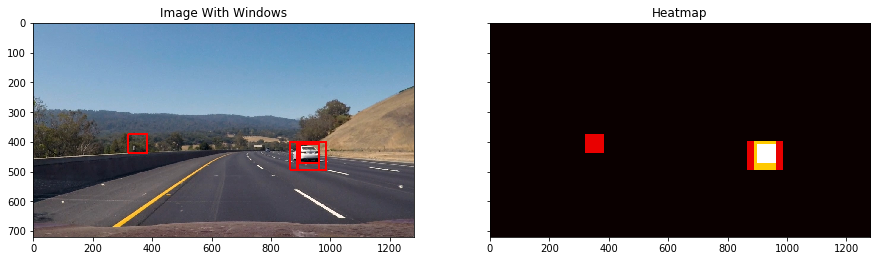

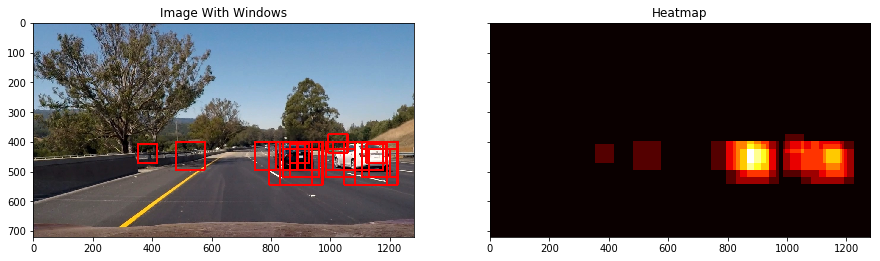

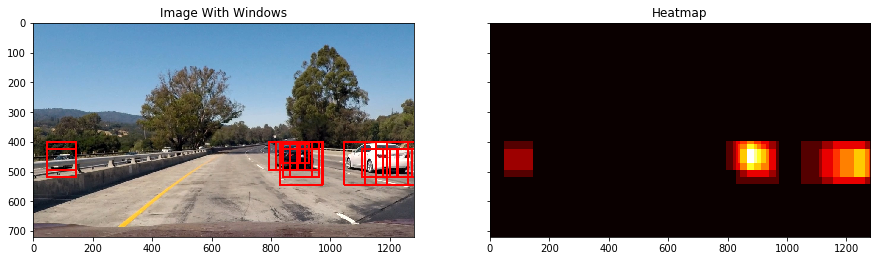

In [20]:
image_paths = glob.glob('./test_images/test*.jpg')

for path in image_paths:
    image = mpimg.imread(path)

    window_img, hot_windows = process_single_image(image)
    fig, axes = plt.subplots(ncols=2, figsize=(15, 7), sharex=True, sharey=True, subplot_kw={'adjustable':'box-forced'})
    ax0, ax1 = axes
    ax0.imshow(window_img)
    ax0.set_title("Image With Windows")
    hmap_img = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(hmap_img, hot_windows)

    ax1.imshow(heatmap, cmap='hot')
    ax1.set_title("Heatmap")
    plt.show()

In [6]:
class hot_windows_buffer():
    def __init__ (self):
        self.queue_max_len = 100 # number items to store
        self.last_windows = []

    def store_prev_hot_windows (self, boxes):
        if (len(self.last_boxes) > self.queue_max_len):
            tmp = self.last_windows.pop (0)
        
        self.last_windows.append (boxes)
        
    def get_prev_hot_windows (self):
        b = []
        for window in self.last_windows:
            b.extend(window)
        return b




def process_video(image):
    global heat_threshold
    global enable_diag

    # Save a raw image
    draw_image = np.copy(image)
    # Normalize image
    image = image.astype(np.float32)/255
    # Apply pipeline to the image to create black and white image
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    
    heat_threshold = 35
    buffered_frames = frame_buf.get_prev_hot_windows()
    frame_buf.store_prev_hot_windows (hot_windows)
    buffered_frames = frame_buf.get_prev_hot_windows()
    #get final windows
    car_windows, buffered_frames = create_car_windows(buffered_frames, draw_image)
    mult_found_win = 5    #weight to be applied to the succesfully found windows
    if np.count_nonzero(buffered_frames)>0:
        # increase the size of the window to get better tracking
        buffered_frames[:,0,0] = buffered_frames[:,0,0] - 10
        buffered_frames[:,0,1] = buffered_frames[:,0,1] - 3
        buffered_frames[:,1,0] = buffered_frames[:,1,0] + 10
        buffered_frames[:,1,1] = buffered_frames[:,1,1] + 3
        
        # store weighted found windows in the buffer
        buffered_frames = np.tile(buffered_frames,(mult_found_win,1,1))
        frame_buf.store_prev_hot_windows(buffered_frames)
    else:
        # no windows found
        buffered_frames = np.zeros((1,2,2))

    
    # diagnostics mode to troubleshoot the algo
    if enable_diag:
        hmap_img = np.zeros_like(image[:,:,0]).astype(np.uint16)
        heatmap = 25*np.array(add_heat(hmap_img, hot_windows)).astype(np.uint16)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_GRAY2RGB)
        heatmap_buf = 25*np.array(add_heat(hmap_img, buffered_frames)).astype(np.uint16)
        heatmap_buf = cv2.cvtColor(heatmap_buf, cv2.COLOR_GRAY2RGB)
        
        heatmap_buf = np.clip(heatmap_buf, a_max=255, a_min=0)

        diagFrame = np.zeros((1080, 1920, 3), dtype=np.uint8)
        diagFrame[0:720, 0:1280] = car_windows
        diagFrame[0:480, 1280:1920] = cv2.resize(heatmap, (640,480), interpolation=cv2.INTER_AREA) 
        diagFrame[480:960, 1280:1920] = cv2.resize(heatmap_buf, (640,480), interpolation=cv2.INTER_AREA) 

        return diagFrame
 
    else:
        return car_windows

In [7]:
frame_buf = hot_windows_buffer()

white_output = './output/project_video_output.mp4' 
clip1 = VideoFileClip('project_video.mp4').subclip(12,16) # Original video
white_clip = clip1.fl_image(process_video) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)

# make a sound when video processing is done
Audio(url=sound_file, autoplay=True)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


 99%|█████████▉| 100/101 [00:48<00:00,  2.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



In [29]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('./output/project_video_output.mp4'))